In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from arch import arch_model
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
data = yf.download('AAPL', start='2010-01-01')
df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df.index)
df.set_index('Date', inplace=True)
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.440331,6.455077,6.391279,6.422877,493729600
2010-01-05,6.451465,6.487878,6.417459,6.458085,601904800
2010-01-06,6.348848,6.477047,6.342228,6.451467,552160000
2010-01-07,6.337110,6.379843,6.291067,6.372319,477131200
2010-01-08,6.379241,6.379843,6.291368,6.328684,447610800


In [4]:
df['Returns'] = df['Close'] - df['Close'].shift(1)
df['log_returns'] = np.log(df['Close']/df['Close'].shift(1))
df['Volatility_annualised'] = df['log_returns'].rolling(window=21).std() * np.sqrt(252)
df.dropna(inplace=True)

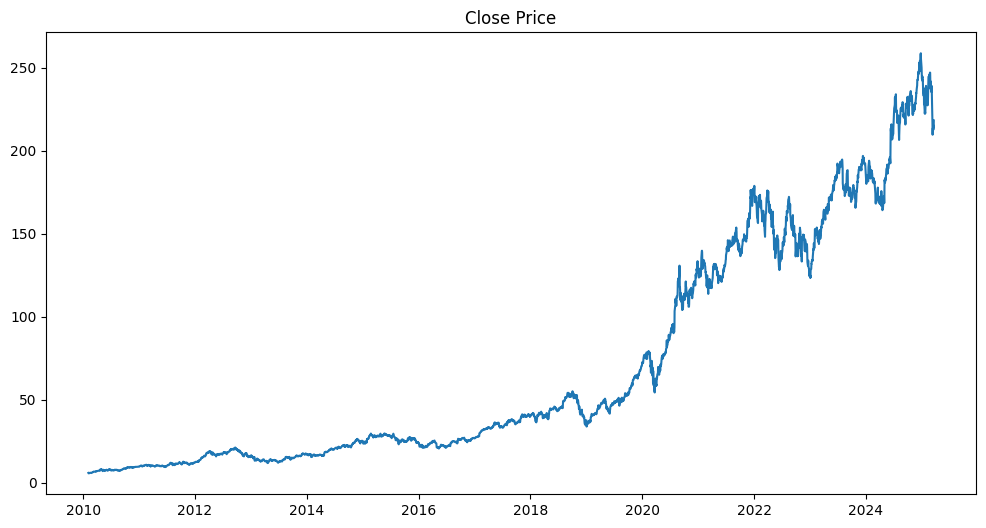

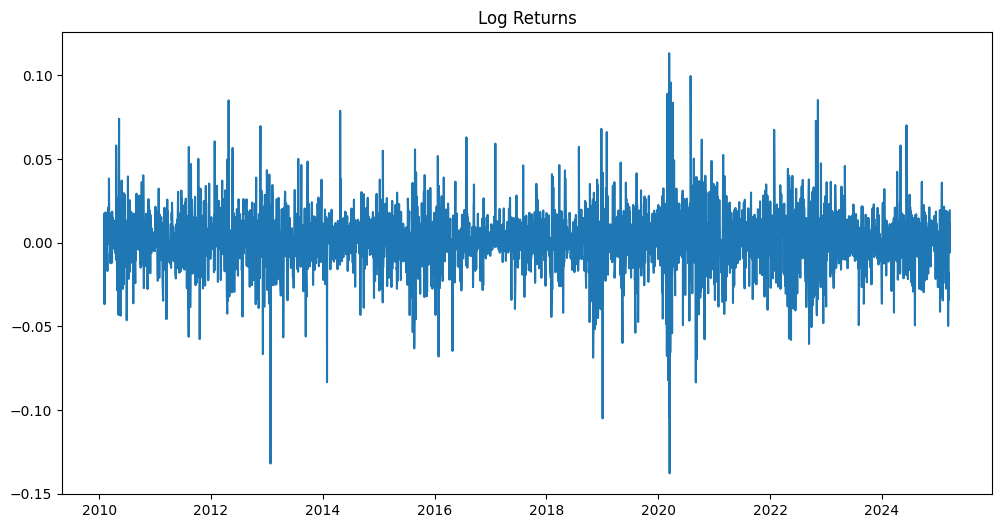

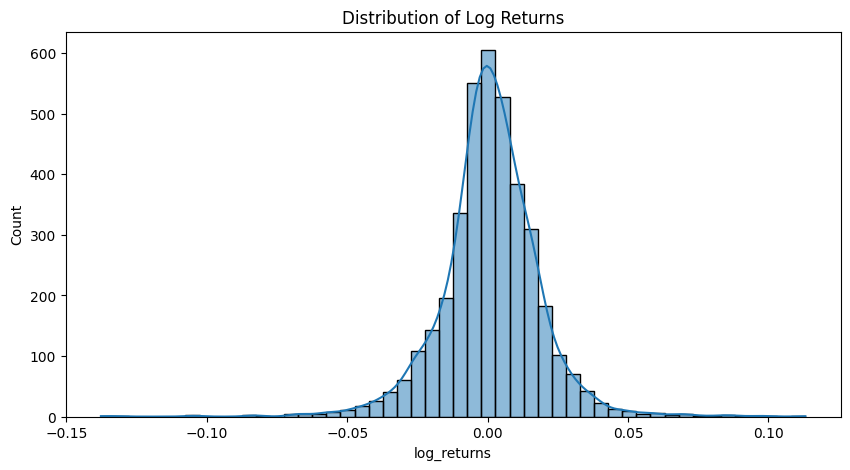

In [5]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'])
plt.title("Close Price")
plt.show()

# Plot log returns
plt.figure(figsize=(12,6))
plt.plot(df.index, df['log_returns'])
plt.title("Log Returns")
plt.show()

# Histogram of log returns
plt.figure(figsize=(10,5))
sns.histplot(df['log_returns'], bins=50, kde=True)
plt.title("Distribution of Log Returns")
plt.show()

ADF Statistic: -20.422537
p-value: 0.000000


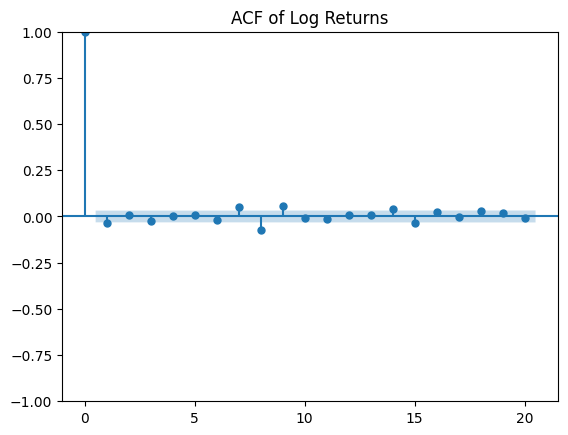

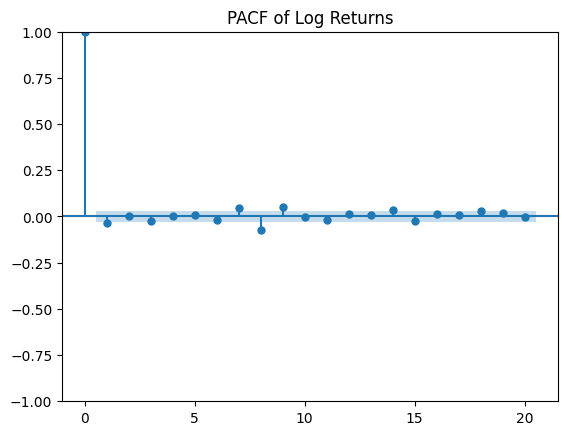

In [6]:
# Stationarity check using ADF test
result = adfuller(df['log_returns'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# ACF and PACF plots for log returns
plot_acf(df['log_returns'].dropna(), lags=20)
plt.title("ACF of Log Returns")
plt.show()

plot_pacf(df['log_returns'].dropna(), lags=20)
plt.title("PACF of Log Returns")
plt.show()

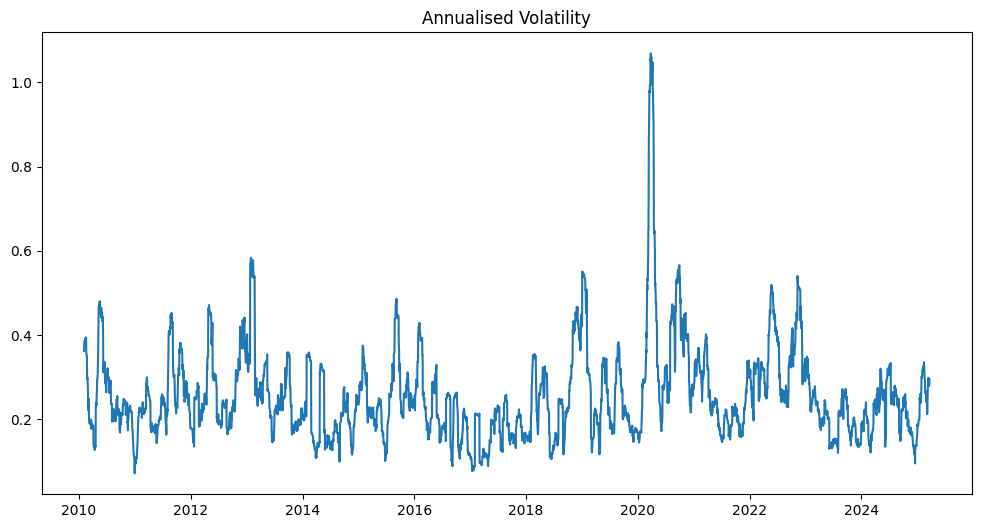

In [7]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Volatility_annualised'])
plt.title("Annualised Volatility")
plt.show()

In [8]:
split_index = int(len(df) * 0.6)
train_returns = df['log_returns'].iloc[:split_index]
test_returns = df['log_returns'].iloc[split_index:]
dates_test = test_returns.index

predicted_vols = []

# Loop through each time step in the test set
for i in range(len(test_returns)):
    # Use an expanding window: training data plus test data up to time i
    data_up_to_now = df['log_returns'].iloc[:split_index + i]
    
    # Fit the GARCH(1,1) model (scaling returns by 100 if needed)
    model = arch_model(data_up_to_now * 100, vol='EGARCH', p=1, q=1, dist='Normal')
    model_fit = model.fit(disp="off")
    
    # One-step ahead forecast
    forecast = model_fit.forecast(horizon=1)
    # Extract predicted variance, then compute standard deviation
    vol_forecast = np.sqrt(forecast.variance.values[-1, 0]) / 100
    predicted_vols.append(vol_forecast)

# Create a DataFrame for plotting
forecast_df = pd.DataFrame({
    'Predicted_Vol': predicted_vols,
    'Realized_Vol': df['Volatility_annualised'].iloc[split_index:]  # or compute a one-day realized volatility
}, index=dates_test)


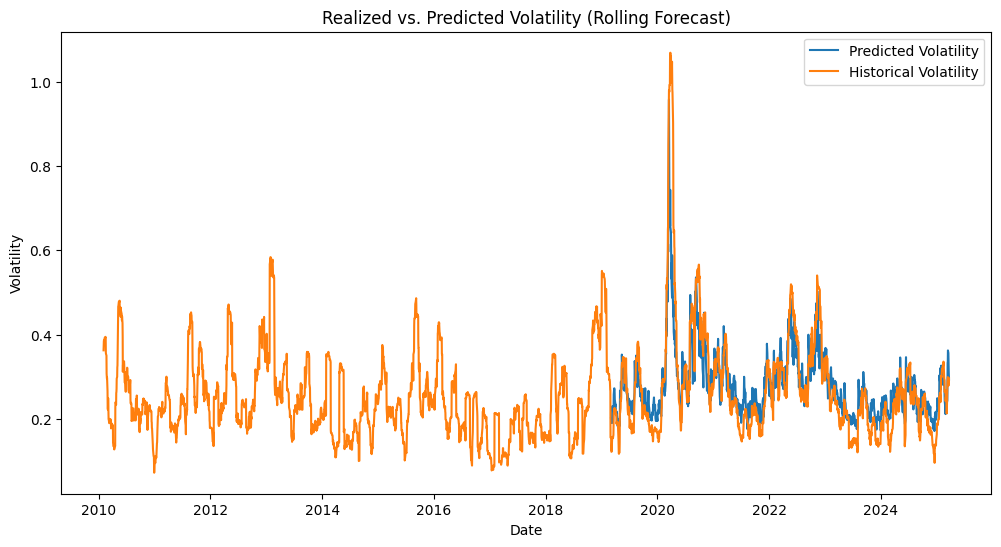

In [9]:
# Plot the forecasts vs realized volatility
plt.figure(figsize=(12,6))
plt.plot(forecast_df.index, forecast_df['Predicted_Vol'] * np.sqrt(252), label='Predicted Volatility')  # annualize if necessary
plt.plot(df.index, df['Volatility_annualised'], label='Historical Volatility')
plt.title("Realized vs. Predicted Volatility (Rolling Forecast)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

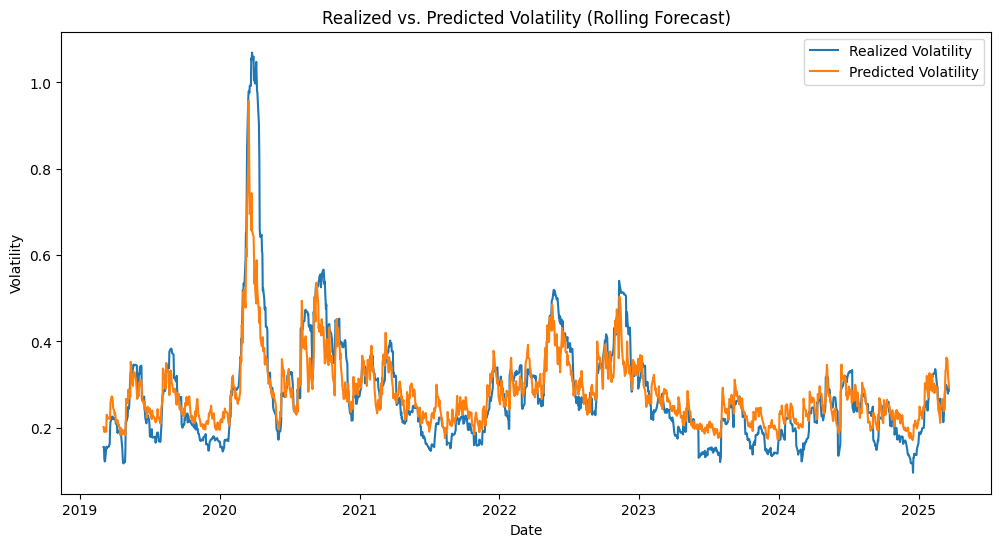

In [10]:
# Plot the forecasts vs realized volatility
plt.figure(figsize=(12,6))
plt.plot(forecast_df.index, forecast_df['Realized_Vol'], label='Realized Volatility')
plt.plot(forecast_df.index, forecast_df['Predicted_Vol'] * np.sqrt(252), label='Predicted Volatility')  # annualize if necessary
plt.title("Realized vs. Predicted Volatility (Rolling Forecast)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()